In [95]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
%matplotlib inline

In [96]:
sales_of_company_x = pd.read_csv("monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("daily-total-female-births-in-cal.csv")

In [107]:
def adfuller_show(y):
    dft = adfuller(y, autolag='AIC')
    dfoutput = pd.Series(dft[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dft[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

def acdf(y):
    with plt.style.context('bmh'):
        plt.figure(figsize=(16, 8))
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        ts_ax.set_title('Original')
        pd.Series(y).plot(ax=ts_ax, color='blue', label='Or')
        smt.graphics.plot_acf(y, lags=None, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=None, ax=pacf_ax, alpha=0.05)

    plt.tight_layout()

def show_result(y):
    adfuller_show(y)
    acdf(y)

Датасет по продажам:
     - видим что дисперсия растет
     - есть тренд
Проверим первичиный ряд на стационарность тестом Дикки-Фуллера: p-value слишком высок (превышает порог 0.05), чтобы отбросить нулевую гипотезу о нестационарности ряда. поэтому считаем, что ряд стационарен. Это видно и на кореллограмме - видны условно большие значения крелляций в районе лагов 10-13. На частичной кореллограмме видим аномальный выброс в районе 17 лага.
 - уменьшим изменчивость дисперсии с помощью преобразования Бокса-Кокса
 - избавимся от тренда и периодичности с помощью дифференцирования

Test Statistic                  0.654715
p-value                         0.988889
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


C:\ProgramFiles\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


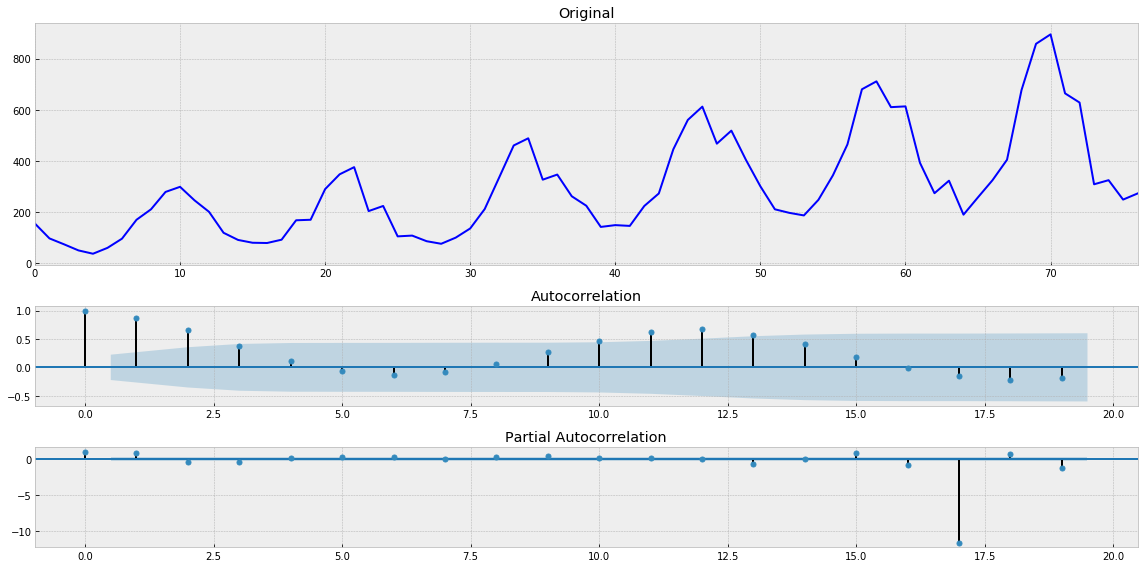

In [108]:
x = [i for i in range(len(sales_of_company_x['Count']))]
y = sales_of_company_x['Count']
show_result(y)

Test Statistic                 -0.908049
p-value                         0.785310
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


C:\ProgramFiles\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


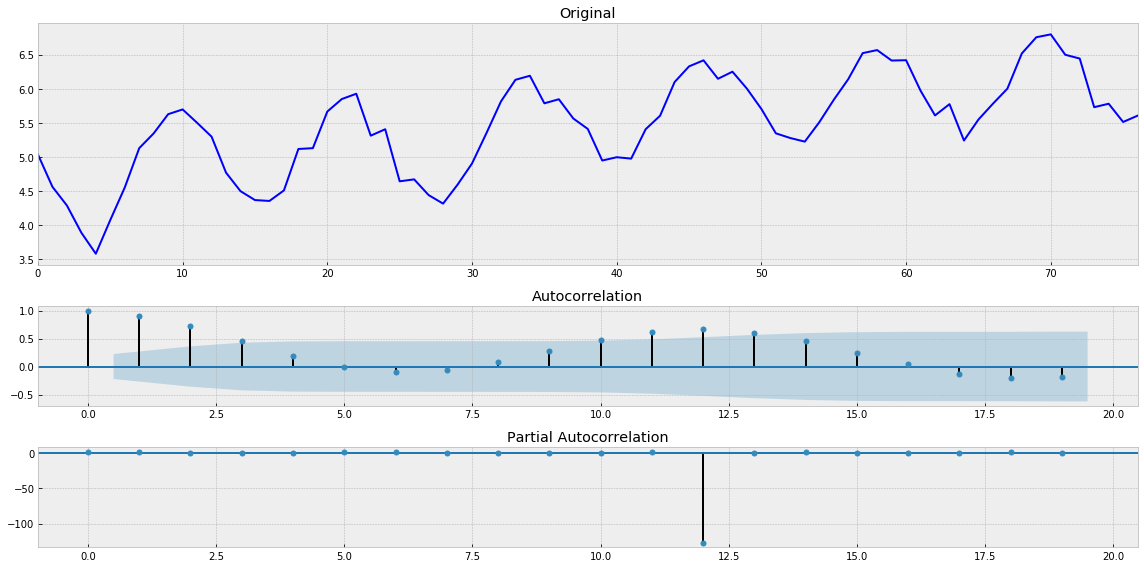

In [111]:
#выравним дисперсию  помощью метода Бокса-Кокса (0 - логарифмирование)
series =  boxcox(y, 0)
show_result(series)

Test Statistic                 -3.135644
p-value                         0.024025
#Lags Used                     11.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


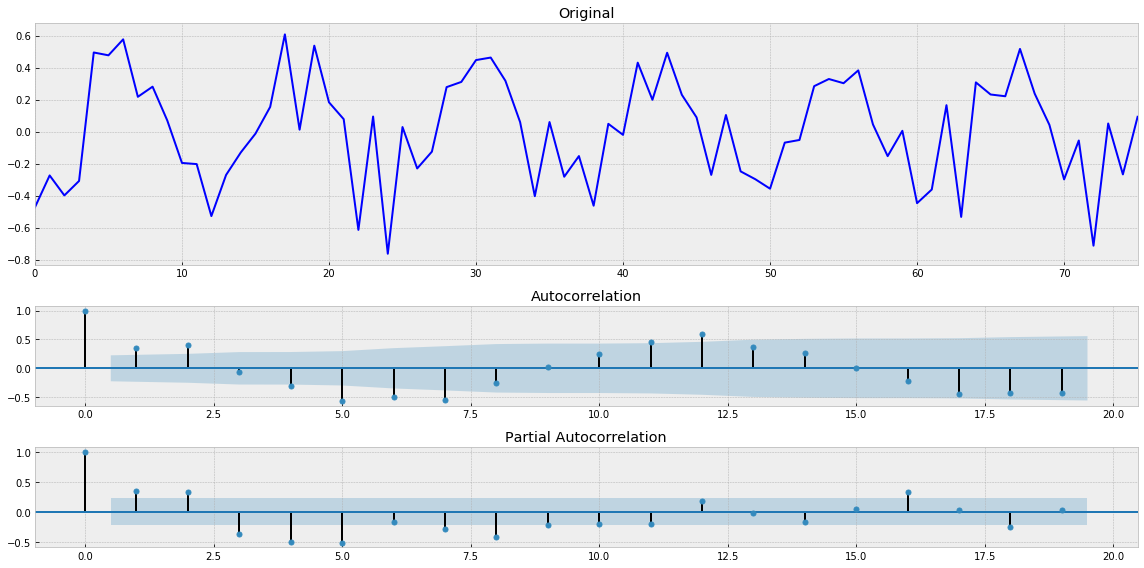

In [112]:
#избавимся от тренда с помощью дифференцирования
step = 1
series1 = np.diff(series, step)
show_result(series1)

P-value уже хорош 0,02 и уже можно принять гипотезу, что это стационарный ряд, но из кореллограммы видна все еще некоторая сезонность, да и корреляции высоковаты. поэтому еще раз проведем дифференциацию

Test Statistic                -7.101182e+00
p-value                        4.164137e-10
#Lags Used                     1.100000e+01
Number of Observations Used    6.300000e+01
Critical Value (1%)           -3.538695e+00
Critical Value (5%)           -2.908645e+00
Critical Value (10%)          -2.591897e+00
dtype: float64


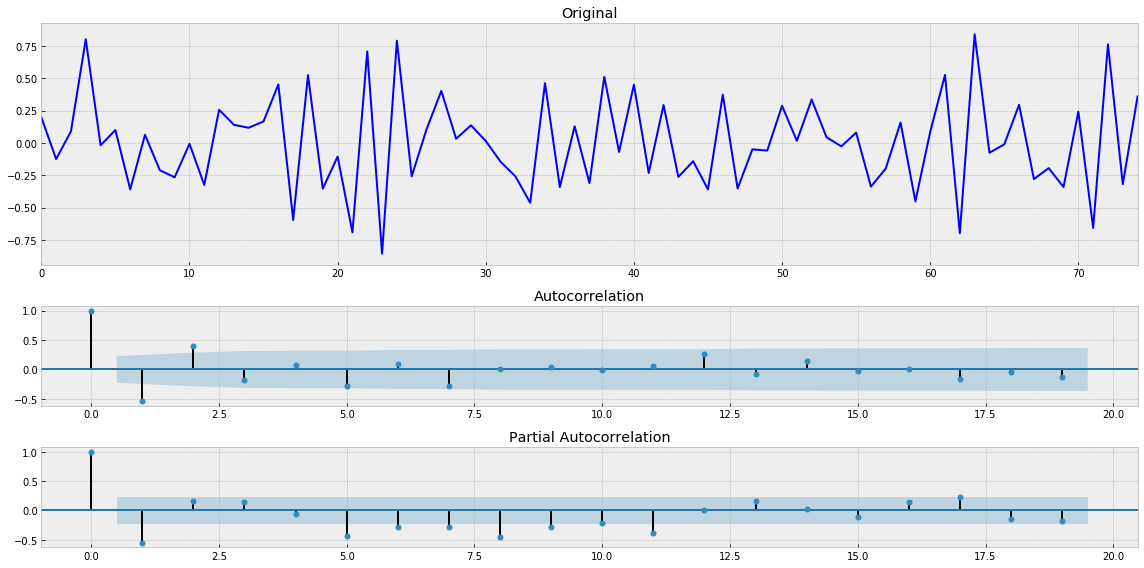

In [115]:
step = 1
series2 = np.diff(series1, step)
show_result(series2)

p-value очень близок к нулю, да и корреляции для лагов находяся в корридоре доверительного интервала. 

Test Statistic                 -2.316045
p-value                         0.166845
#Lags Used                     10.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64


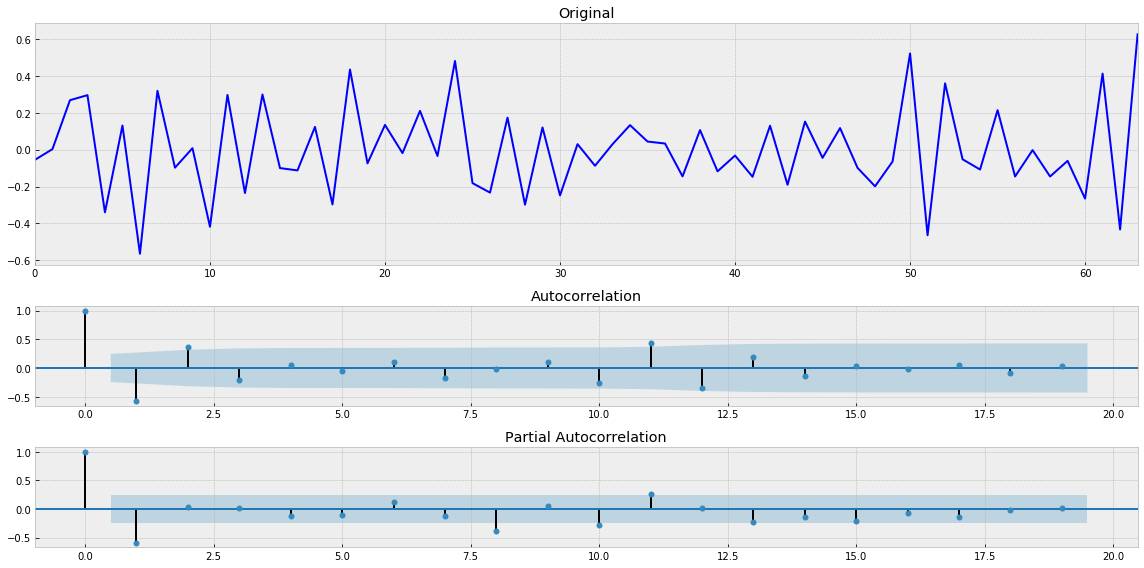

In [119]:
#попробуем другой способ убрать сезонность с помощью вычитания даннх с лагом, равнм периоду сезонности 
series12 = series1[12:] - series1[:-12]
show_result(series12)

Кореллограммы и на вид график получились вполне хорошими, а вот p-value высоковат. какие тут выводы можно сделать?

Датасет по вооруженным ограбелениям:

 - видим что дисперсия растет
 - есть тренд

Проверим первичиный ряд на стационарность тестом Дикки-Фуллера: p-value слишком высок (превышает порог 0.05), чтобы отбросить нулевую гипотезу о нестационарности ряда. поэтому считаем, что ряд не стационарен. Это видно и на кореллограмме - корелляциции медленнно уменьаются с увеличением лага.

уменьшим изменчивость дисперсии с помощью преобразования Бокса-Кокса
избавимся от тренда и периодичности с помощью дифференцирования

Test Statistic                   1.001102
p-value                          0.994278
#Lags Used                      11.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


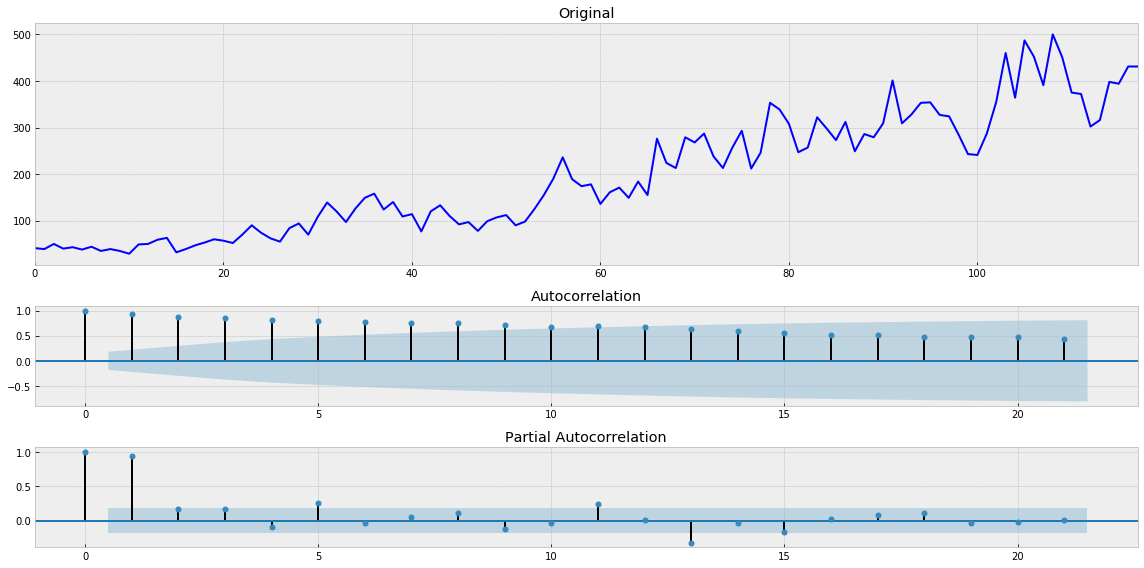

In [121]:
x = [i for i in range(len(robberies_in_boston['Count']))]
y = robberies_in_boston['Count']
show_result(y)

Test Statistic                  -2.013161
p-value                          0.280833
#Lags Used                      10.000000
Number of Observations Used    107.000000
Critical Value (1%)             -3.492996
Critical Value (5%)             -2.888955
Critical Value (10%)            -2.581393
dtype: float64


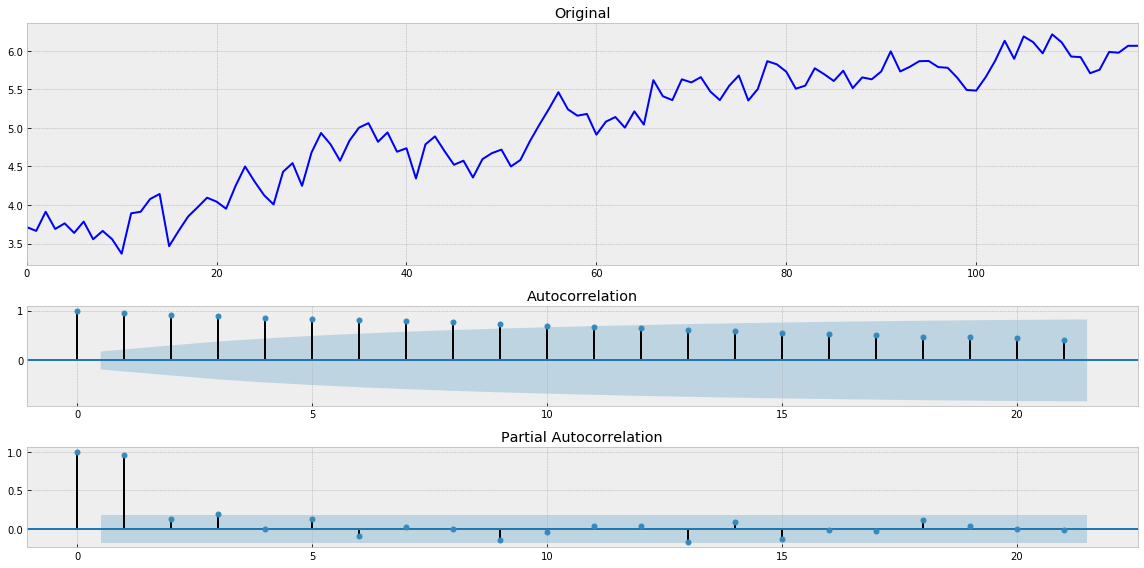

In [123]:
series =  boxcox(y, 0)
show_result(series)

Test Statistic                -7.601792e+00
p-value                        2.378602e-11
#Lags Used                     3.000000e+00
Number of Observations Used    1.130000e+02
Critical Value (1%)           -3.489590e+00
Critical Value (5%)           -2.887477e+00
Critical Value (10%)          -2.580604e+00
dtype: float64


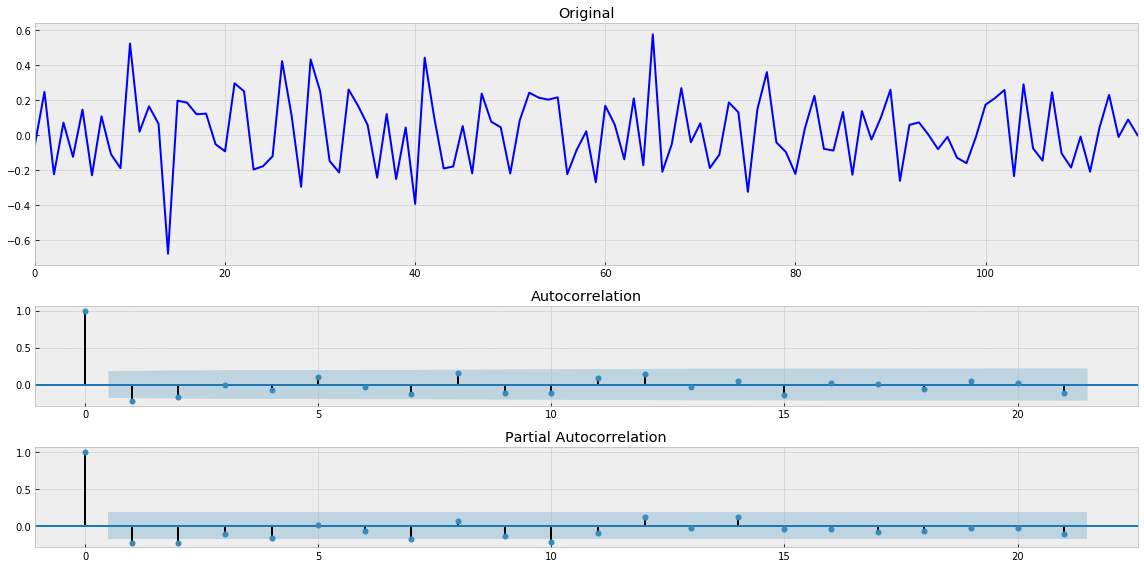

In [124]:
#избавимся от тренда с помощью дифференцирования
step = 1
series1 = np.diff(series, step)
show_result(series1)

p-value очень низкий и значения корелляций находятся в доверительном интервал и близко к нулю, что позволяет сделать вывод о том, что ряд стационарен

Датасет по международным перелетам:

 - видим что дисперсия растет
 - есть тренд
 
Проверим первичиный ряд на стационарность тестом Дикки-Фуллера: p-value слишком высок (превышает порог 0.05), чтобы отбросить нулевую гипотезу о нестационарности ряда. поэтому считаем, что ряд не стационарен. Это видно и на кореллограмме - корелляции медленно уменьшаются с увеличеинем лага. На частичной кореллограмме видим явную сезонность в районе 13 лага.

    - уменьшим изменчивость дисперсии с помощью преобразования Бокса-Кокса
    - избавимся от тренда и периодичности с помощью дифференцирования

Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


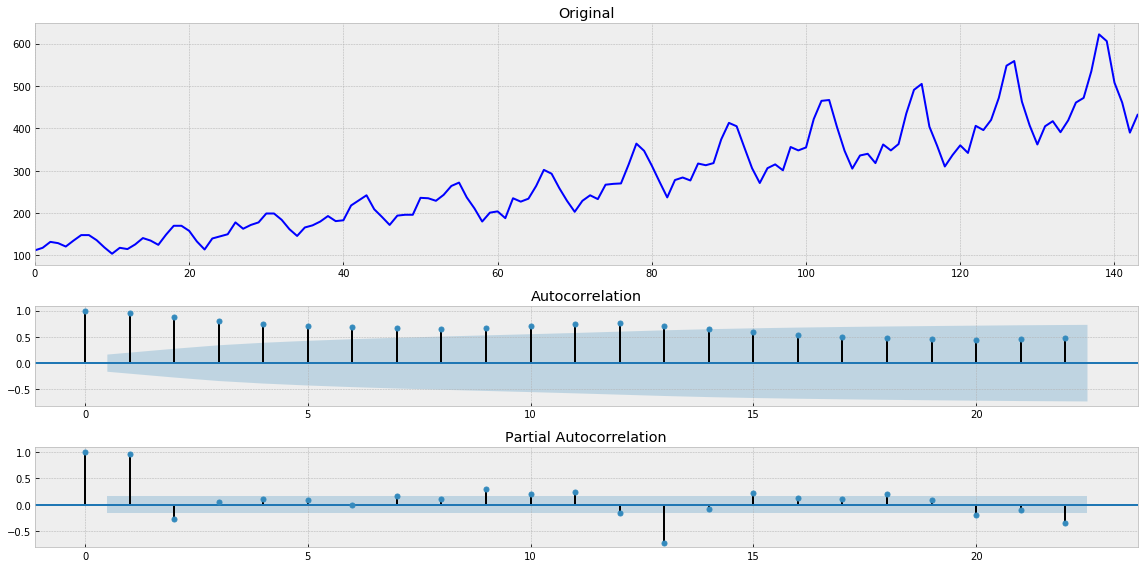

In [125]:
x = [i for i in range(len(airlines_passengers['Count']))]
y = airlines_passengers['Count']
show_result(y)

Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


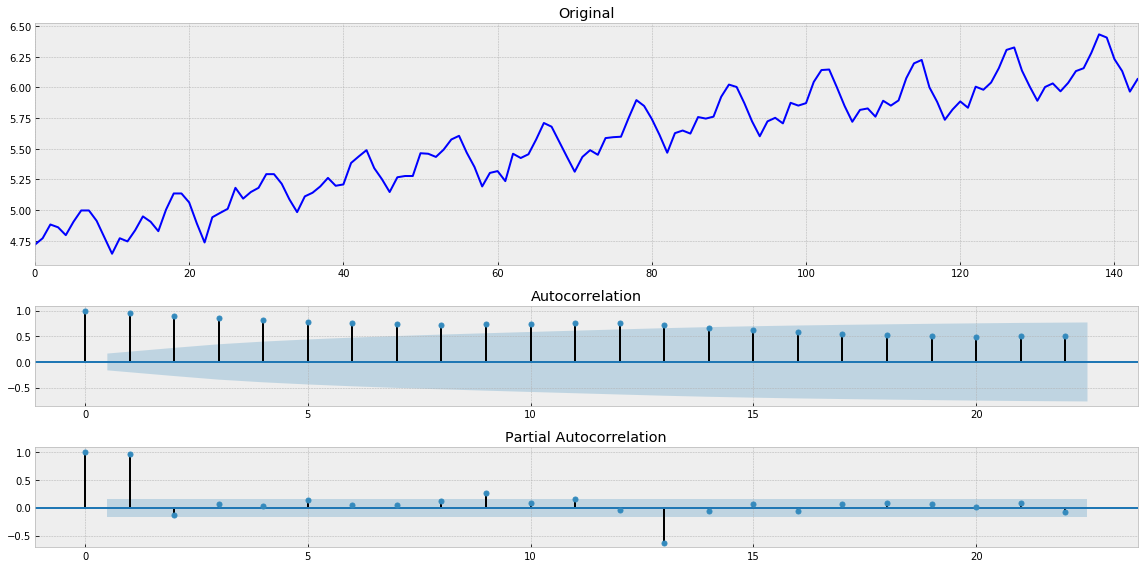

In [126]:
series =  boxcox(y, 0)
show_result(series)

Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


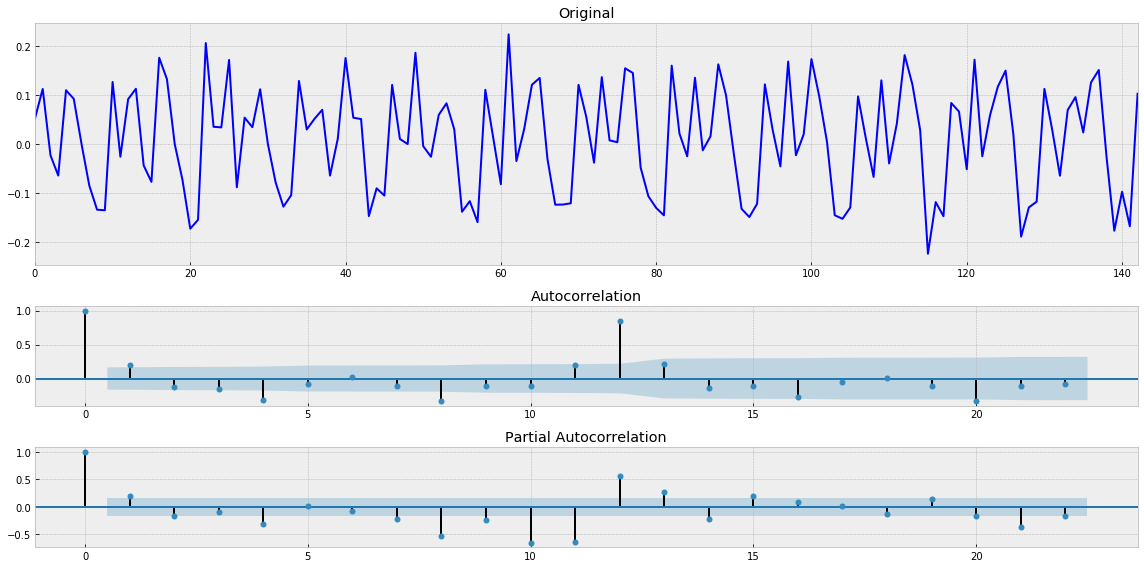

In [127]:
step = 1
series1 = np.diff(series, step)
show_result(series1)

пока p-value высоковат и на кореллограмме видна всокая корелляция на 12м лаге, близкая к 1, то говорит сезонности. избавимся от нее с помощью метода дифференцирования

Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


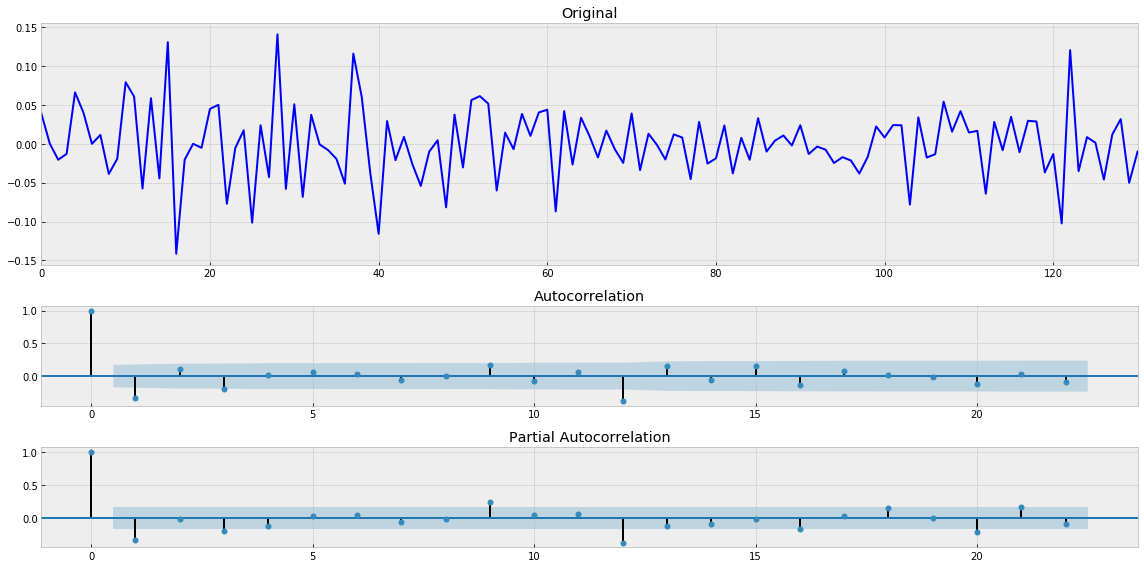

In [128]:
series2 = series1[12:] - series1[:-12]
show_result(series2)

теперь p-value досаточно низкий и на кореллограмме та высокая корреляцию ушла, что дает нам право считать ряд стационарным

Датасет по среднемесячной температуре:

 - видим сезонность, которую уберем методо диффернцирования
 
Проверим первичиный ряд на стационарность тестом Дикки-Фуллера: p-value достаточно низок


Test Statistic                  -3.255492
p-value                          0.016989
#Lags Used                      14.000000
Number of Observations Used    225.000000
Critical Value (1%)             -3.459752
Critical Value (5%)             -2.874473
Critical Value (10%)            -2.573663
dtype: float64


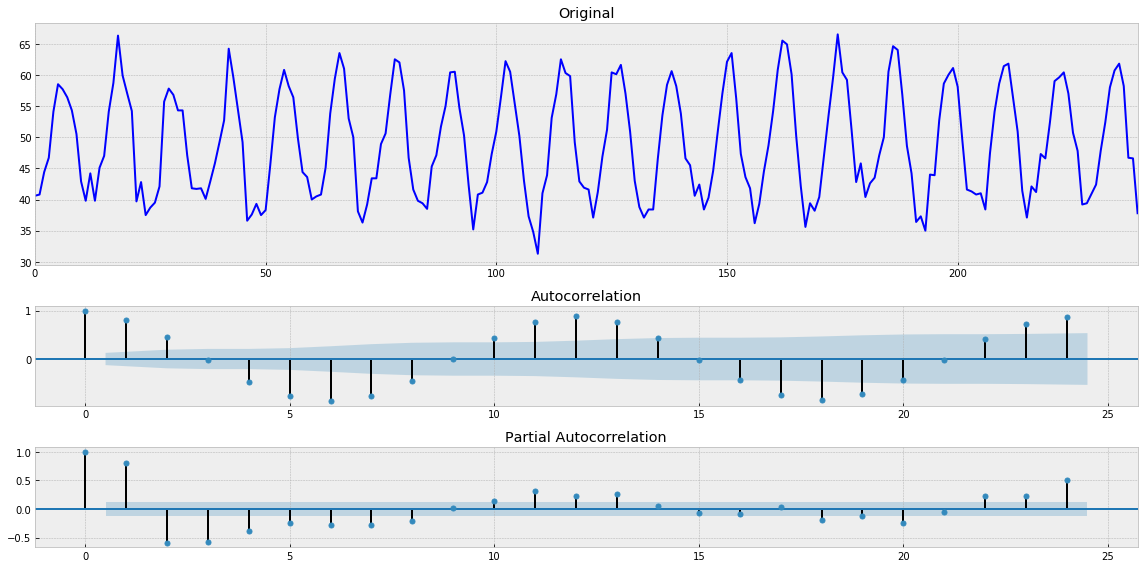

In [132]:
x = [i for i in range(len(mean_monthly_temp['Deg']))]
y = mean_monthly_temp['Deg']
show_result(y)

Test Statistic                -1.225927e+01
p-value                        9.157883e-23
#Lags Used                     1.100000e+01
Number of Observations Used    2.270000e+02
Critical Value (1%)           -3.459490e+00
Critical Value (5%)           -2.874358e+00
Critical Value (10%)          -2.573602e+00
dtype: float64


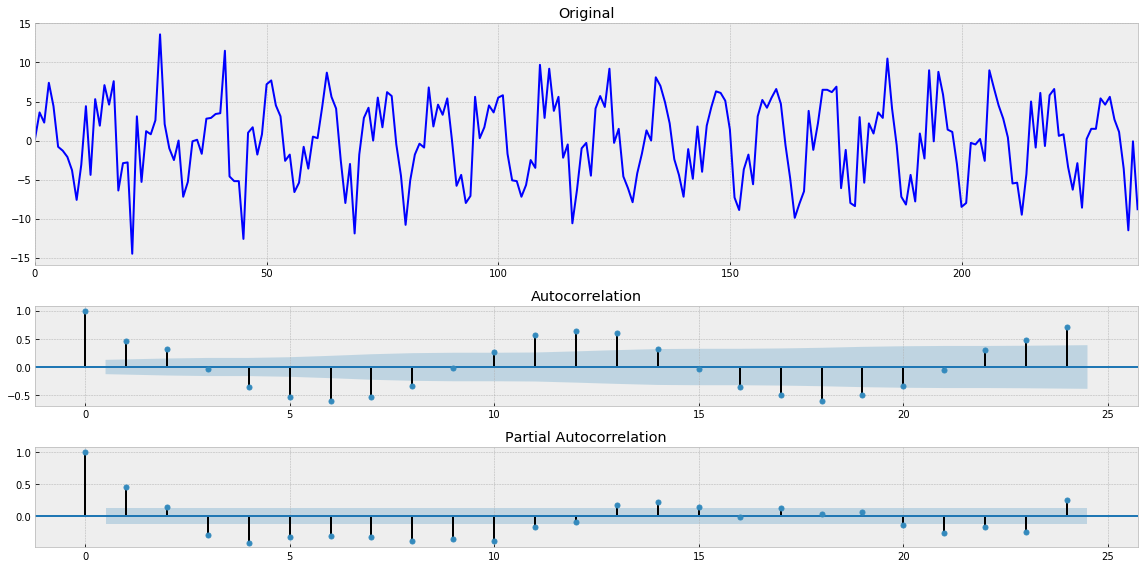

In [134]:
step = 1
series1 = np.diff(y, step)
show_result(series1)

p-value еще уменьшился, но кореллограмма имеет высокие значения, выходящие за коридор доверительного интервала. На груфике видна сезонность. поэтому проведем повторное дифференцирование

Test Statistic                -1.041098e+01
p-value                        1.804502e-18
#Lags Used                     1.500000e+01
Number of Observations Used    2.220000e+02
Critical Value (1%)           -3.460154e+00
Critical Value (5%)           -2.874649e+00
Critical Value (10%)          -2.573757e+00
dtype: float64


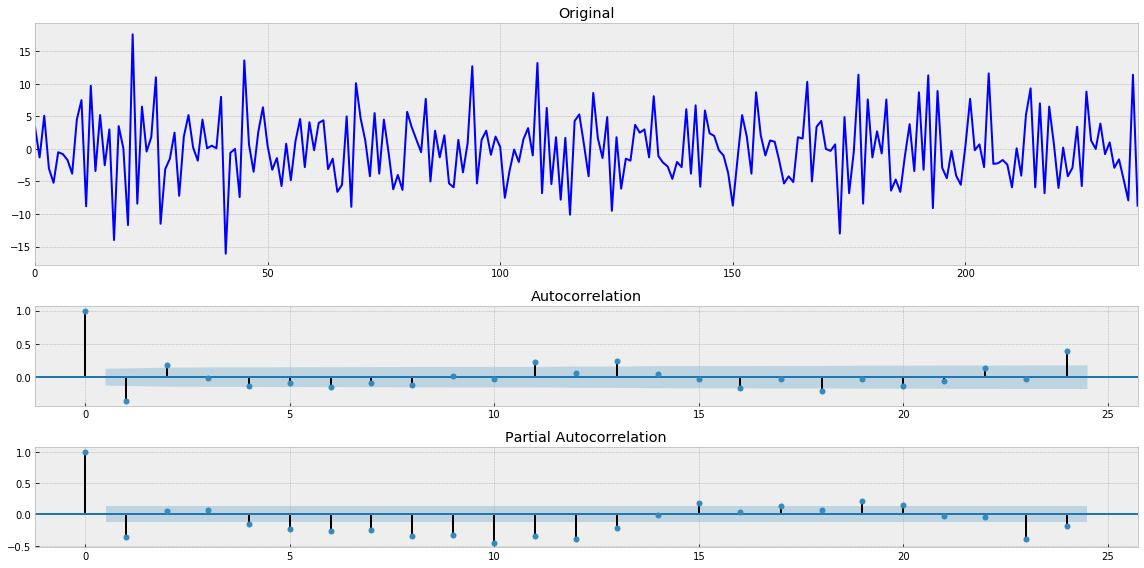

In [135]:
step = 1
series2 = np.diff(series1, step)
show_result(series2)

p-vaule стал еще меньше, а вот кореллограмма выглядит гораздо лучше: большинство корелция находится в коридоре доверительного интервала и резко уменьшается и близко к нулю. следовательно, ряд стационарен

Датасет по индексу Доу-Джонса:

 - из общего графика нельзя точно сказать про тренда, но похоже он есть и убывающий.
 
Проверим первичиный ряд на стационарность тестом Дикки-Фуллера: p-value достаточно высок, следовательно принимаем гипотезу о том, что ряд не стационарен. о том же говорит медленно убывающая кореллограмма


Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


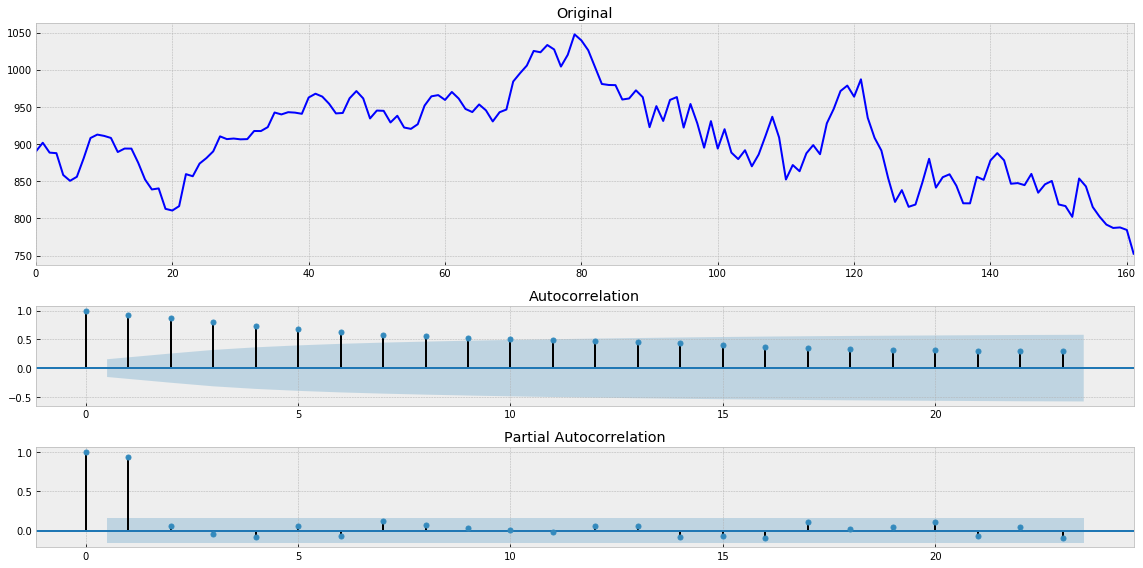

In [137]:
x = [i for i in range(len(dowjones_closing['Close']))]
y = dowjones_closing['Close']
show_result(y)

Test Statistic                -1.302521e+01
p-value                        2.407586e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


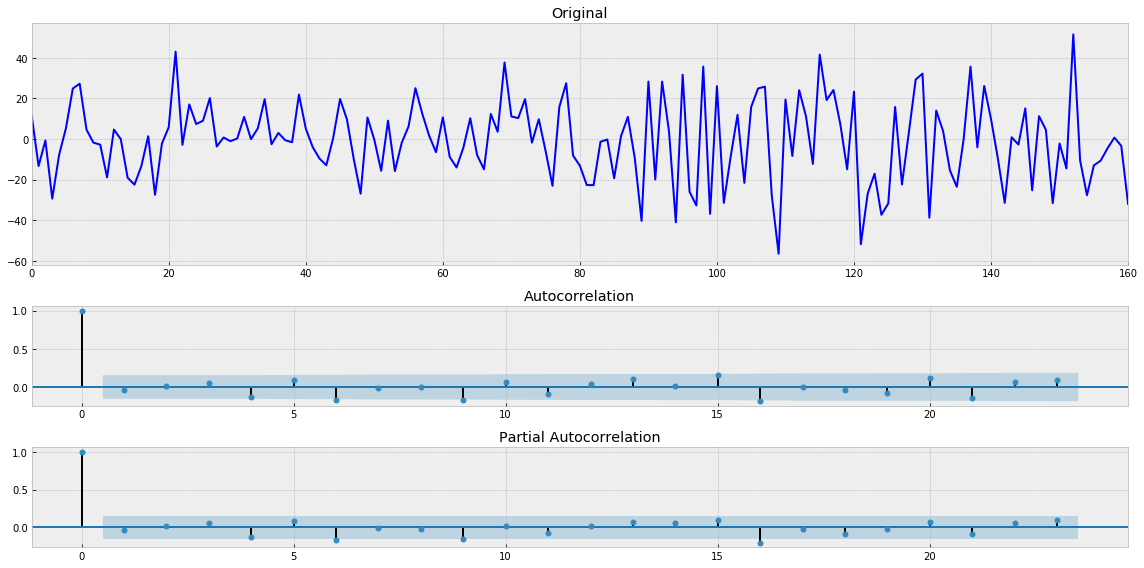

In [139]:
step = 1
series1 = np.diff(y, step)
show_result(series1)

применив дифферренцирование мы получаем низкое p-value, достаточное, чтобы отвергнуть гипотезу о нестационарности ряда и на кореллограмме все отчеты корелляций близки к нулю и находят в коридоре доверительного интервала, что говорит нам о том что ряд стал стационарным

Датасет по статистике рождения женщин:

 - из общего графика нельзя точно сказать про тренда, но похоже он есть и убывающий.
 
Проверим первичиный ряд на стационарность тестом Дикки-Фуллера: p-value достаточно высок, следовательно принимаем гипотезу о том, что ряд не стационарен. о том же говорит медленно убывающая кореллограмма


Test Statistic                  -4.808291
p-value                          0.000052
#Lags Used                       6.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64


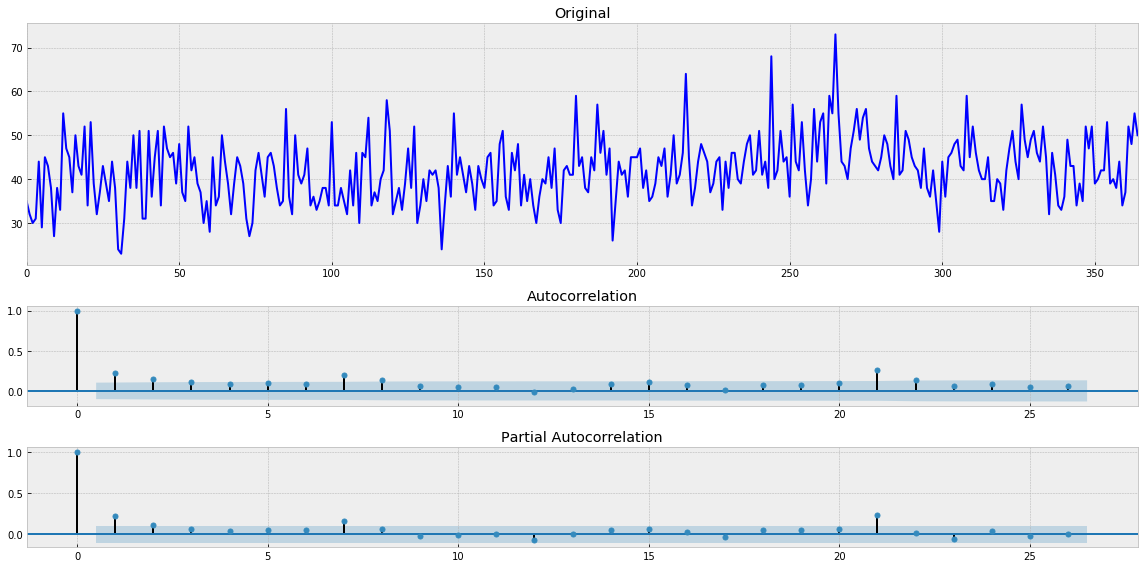

In [142]:
x = [i for i in range(len(female_births['Count']))]
y = female_births['Count']
show_result(y)

Думаю, здесь и p-value достаточно низок и корелляии находятся в коридоре доверительного интервала, поэтому можно сказать что ряд стационарен. Ниже я его продифференцировал, но график частично корелляции стал выглядить похуже, хотя pvaue еще уменьшился.

Test Statistic                -1.262518e+01
p-value                        1.547240e-23
#Lags Used                     6.000000e+00
Number of Observations Used    3.570000e+02
Critical Value (1%)           -3.448801e+00
Critical Value (5%)           -2.869670e+00
Critical Value (10%)          -2.571101e+00
dtype: float64


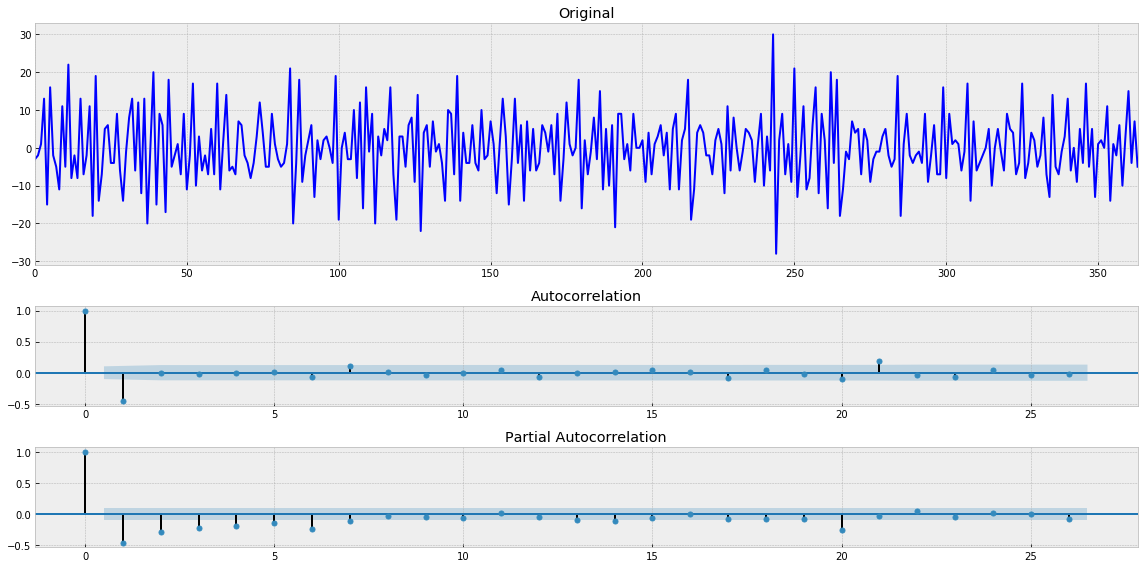

In [144]:
step = 1
series1 = np.diff(y, step)
show_result(series1)